In [2]:
%reload_ext autoreload
%autoreload 2
os.chdir("..")
import toml
from core.dl_framework.utils import read_config
%%bash 
pwd

In [11]:
config_file = toml.load("configs/default_train_config.toml")
setup_config = read_config(config_file)

In [115]:
from core.dl_framework.learner import Learner
from core.dl_framework.data import get_dataset, Dataset, DataLoader, split_data
bs = setup_config["h_batch_size"]
x_train, y_train, x_test, y_test = get_dataset(setup_config["s_source"], setup_config["s_set"], setup_config["p_tmp_data_path"])
train_ds, test_ds =  Dataset(x_train, y_train), Dataset(x_test, y_test)
train_dl, valid_dl = DataLoader(train_ds, bs), DataLoader(test_ds, bs)

tensor(4)

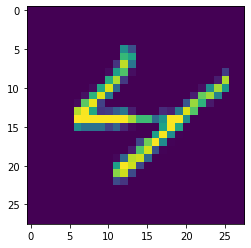

In [128]:
learn = Learner(train_ds, setup_config)
vars(learn)
# import matplotlib.pyplot as plt
plt.imshow(learn.data.valid_ds[1][0].float().reshape(28, -1))
#train_ds, valid_s = split_trainset_ds(train_ds, 0.2)
#len(train_ds)
# len(train_ds)
# len(learn.data[1])+
learn.data.valid_ds[1][1]


In [110]:
train_dl.dataset

In [79]:
class test_class():
    def __init__(self, a, b):
        self.a = a
        self.b = self.func(b)

    def func(self):
        return arg+1
vars(test_class(1, 2))

TypeError: func() takes 1 positional argument but 2 were given